In [1]:
%load_ext autoreload
%autoreload 2
# import pandas as pd
import scripts.config as cfg
from os.path import join
from analysis_settings import *
from plot_settings import *
import numpy as np
import matplotlib.pyplot as plt
from scripts.cluster_stats import lineplot_compare, _pval_correction_lineplot
from scripts.utils_plot import _save_fig, _axes2d, explode_df, _add_band_annotations
from matplotlib.lines import Line2D
from pte_stats import cluster, timeseries
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Patch
from itertools import product

In [2]:
# n_perm = int(1e2)
n_perm = int(1e4)
# n_perm = int(1e6)  # imporant to avoid false positive alpha cluster periodic

In [3]:
sns.set_style('darkgrid')
ch_choice = 'ch_dist_sweet'
dataframes = get_dfs(ch_choice, equalize_subjects_norm_abs=False)

/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['sub_hemi_cond'] = df.sub_hemi + '_' + df.cond
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:81: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pivot['UPDRS_exists'] = pivot.UPDRS_bradyrigid_contra.notna()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:82: 

In [4]:
def _remove_single_hemi_subs(df):
    """Remove subject with only one hemisphere."""
    subject_counts = df.subject.value_counts()
    valid_subjects = subject_counts[subject_counts == 2].index
    df = df[df.subject.isin(valid_subjects)]
    return df


def _extract_arrays(df1, df2, x, y, x_max, x_min):
    if 'fm' in x:
        # different projects have different fitting ranges
        cond_arr1 = []
        for _, row1 in df1.iterrows():
            if np.isnan(row1[y]).any():
                raise ValueError(f"NaNs should not be present")
                # continue
            times = row1[x]
            # assert row2[x].all() == times.all()
            x_mask = (times >= x_min) & (times <= x_max)
            times = times[x_mask]
            cond_arr1.append(row1[y][x_mask])
        # use a separate loop since df1 and df2 can have different lengths
        # for non-paired statistics
        cond_arr2 = []
        for _, row2 in df2.iterrows():
            if np.isnan(row2[y]).any():
                raise ValueError(f"NaNs should not be present")
                # continue
            times = row2[x]
            # assert row2[x].all() == times.all()
            x_mask = (times >= x_min) & (times <= x_max)
            times = times[x_mask]
            cond_arr2.append(row2[y][x_mask])

        x_arr = np.stack(cond_arr1).T
        y_arr = np.stack(cond_arr2).T
    else:
        times = df1[x].values[0]
        x_mask = (times >= x_min) & (times <= x_max)
        times = times[x_mask]

        x_arr = np.stack(df1[y].values)[:, x_mask].T
        y_arr = np.stack(df2[y].values)[:, x_mask].T
    return x_arr, y_arr, times


def _extract_arrays_old(df1, df2, x, y, plot_max, x_min, x_max):
    if 'fm' in x:
        # different projects have different fitting ranges
        cond_arr1 = []
        for _, row1 in df1.iterrows():
            if np.isnan(row1[y]).any():
                continue
            times = row1[x]
            # assert row2[x].all() == times.all()
            x_mask = (times >= x_min) & (times <= plot_max)
            times = times[x_mask]
            cond_arr1.append(row1[y][x_mask])
        # use a separate loop since df1 and df2 can have different lengths
        # for non-paired statistics
        cond_arr2 = []
        for _, row2 in df2.iterrows():
            if np.isnan(row2[y]).any():
                continue
            times = row2[x]
            # assert row2[x].all() == times.all()
            x_mask = (times >= x_min) & (times <= plot_max)
            times = times[x_mask]
            cond_arr2.append(row2[y][x_mask])

        x_arr = np.stack(cond_arr1).T
        y_arr = np.stack(cond_arr2).T
    else:
        times = df1[x].values[0]
        x_mask = (times >= x_min) & (times <= x_max)
        times = times[x_mask]

        x_arr = np.stack(df1[y].values)[:, x_mask].T
        y_arr = np.stack(df2[y].values)[:, x_mask].T
    return x_arr, y_arr, times


def _get_clusters(x1, x2, times, alpha_sig=0.05, n_perm=100000,
                  paired_x1x2=True):
    cluster_times = []
    two_tailed = True
    one_tailed_test = 'larger'
    min_cluster_size = 2
    if paired_x1x2:
        data_a = x1 - x2
        data_b = 0.0
    else:
        data_a = x1
        data_b = x2
    if not two_tailed and one_tailed_test == "smaller":
        data_a_stat = data_a * -1
    else:
        data_a_stat = data_a

    p_vals = timeseries.timeseries_pvals(
            x=data_a_stat, y=data_b, n_perm=n_perm, two_tailed=two_tailed)
    clusters, cluster_count = cluster.clusters_from_pvals(
            p_vals=p_vals, alpha=alpha_sig, correction_method='cluster_pvals',
            n_perm=n_perm, min_cluster_size=min_cluster_size)

    x_labels = times.round(2)
    for cluster_idx in range(1, cluster_count + 1):
        index = np.where(clusters == cluster_idx)[0]
        if index.size == 0:
            print("No clusters found.")
            continue
        lims = np.arange(index[0], index[-1] + 1)
        time_0 = x_labels[lims[0]]
        time_1 = x_labels[lims[-1]]
        print(f"Cluster found between {time_0} Hz and" f" {time_1} Hz.")
        cluster_times.append((time_0, time_1))
    cluster_borders = np.array(cluster_times)
    return clusters, cluster_count, cluster_borders


def _plot_clusters(ax, x1, x2, times, clusters, cluster_count,
                   alpha=0.05, color_cluster='k', alpha_plot=.2):

    if isinstance(x2, (int, float)):
        y_arr = np.ones((x1.shape[0], 1))
        y_arr[:, 0] = x2
    else:
        y_arr = x2
    x_arr = x1
    label = f"p ≤ {alpha}"
    for cluster_idx in range(1, cluster_count + 1):
        index = np.where(clusters == cluster_idx)[0]
        if index.size == 0:
            print("No clusters found.")
            continue
        lims = np.arange(index[0], index[-1] + 1)
        y1 = x_arr.mean(axis=1)[lims]
        y2 = y_arr.mean(axis=1)[lims]
        ax.fill_between(x=times[lims], y1=y1, y2=y2, alpha=alpha_plot,
                        color=color_cluster,
                        label=label)


def _set_yscale(ax, cond, kind, yscale, info_title, yticks, yticklabels=None):
    if yscale is None:
        if cond == 'offon_abs':
            yscale = 'symlog'
        elif cond in ['off', 'on']:
            yscale = 'log'
    ax.set_yscale(yscale)
    color = cfg.COLOR_DIC['periodicAP'] if kind == 'periodicBOTH' else 'k'
    if 'log' in yscale and kind != 'periodic':
        formatter = lambda x, pos: f'{x:.1f}'.rstrip('0').rstrip('.')
        ax.yaxis.set_major_formatter(FuncFormatter(formatter))
        # ax.tick_params(which='major', length=2, width=0.5, axis='x')
        # ax.tick_params(which='major', length=2, width=0.5, axis='y',
        #                labelcolor=color)
        ax.tick_params(which='major', axis='y', labelcolor=color)
    if info_title == False:
        if yticks is None:
            yticks = ax.get_yticks()
        # yticklabels = ['' for _ in yticks]
    else:
        yticklabels = yticks
    if yticklabels is None:
        yticklabels = yticks
    elif yticklabels == False:
        yticklabels = ['' for _ in yticks]
    elif isinstance(yticklabels, list):
        pass
    # if cond == 'on':
    #     if yticks is None:
    #         yticks = ax.get_yticks()
    #     yticklabels = ['' for _ in yticks]
    # else:
    #     if yticks is None:
    #         yticks = ax.get_yticks()
    #     yticklabels = yticks
    if yticks is not None:
        ax.set_yticks(yticks, labels=yticklabels)
    # if kind == 'periodicBOTH':
    #     def shifty_up(y):
    #         return y * periodic_shift
    #     def shifty_down(y):
    #         return y / periodic_shift
    #     secax = ax2.secondary_yaxis('right', functions=(shifty_down, shifty_up))
    #     color = cfg.COLOR_DIC['periodic']
    #     secax.tick_params(which='major', axis='y', labelcolor=color)
    #     secax.tick_params(axis='y', which='minor', right=False)
    #     formatter = lambda x, pos: f'{x:.2f}'.rstrip('0').rstrip('.')
    #     secax.yaxis.set_major_formatter(FuncFormatter(formatter))


# def _set_yscale_kinds(ax, cond, kind, yscale, info_title, yticks):
#     if yscale is None:
#         if cond == 'offon_abs':
#             yscale = 'symlog'
#         elif cond in ['off', 'on']:
#             yscale = 'log'
#     ax.set_yscale(yscale)
#     color = cfg.COLOR_DIC['periodicAP'] if kind == 'periodicBOTH' else 'k'
#     if 'log' in yscale and kind != 'periodic':
#         formatter = lambda x, pos: f'{x:.1f}'.rstrip('0').rstrip('.')
#         ax.yaxis.set_major_formatter(FuncFormatter(formatter))
#         # ax.tick_params(which='major', length=2, width=0.5, axis='x')
#         # ax.tick_params(which='major', length=2, width=0.5, axis='y',
#         #                labelcolor=color)
#         ax.tick_params(which='major', axis='y', labelcolor=color)
#     if info_title == False:
#         if yticks is None:
#             yticks = ax.get_yticks()
#         yticklabels = ['' for _ in yticks]
#     else:
#         yticklabels = yticks
#     # if cond == 'on':
#     #     if yticks is None:
#     #         yticks = ax.get_yticks()
#     #     yticklabels = ['' for _ in yticks]
#     # else:
#     #     if yticks is None:
#     #         yticks = ax.get_yticks()
#     #     yticklabels = yticks
#     if yticks is not None:
#         ax.set_yticks(yticks, labels=yticklabels)
    # if kind == 'periodicBOTH':
    #     def shifty_up(y):
    #         return y * periodic_shift
    #     def shifty_down(y):
    #         return y / periodic_shift
    #     secax = ax2.secondary_yaxis('right', functions=(shifty_down, shifty_up))
    #     color = cfg.COLOR_DIC['periodic']
    #     secax.tick_params(which='major', axis='y', labelcolor=color)
    #     secax.tick_params(axis='y', which='minor', right=False)
    #     formatter = lambda x, pos: f'{x:.2f}'.rstrip('0').rstrip('.')
    #     secax.yaxis.set_major_formatter(FuncFormatter(formatter))


# def _shrink_yaxis(x, ax, y, df_exploded, y_freq=10):
#     """Shrink normalized y-axis to better visualize higher frequencies."""
#     ymin, _ = ax.get_ylim()
#     ymax = df_exploded.loc[df_exploded[x] == y_freq, y].quantile(q=.95)
#     ax.set_ylim(ymin, ymax)


def _annotate_stats(ax, all_clusters, color=None, labels=None,
                    total_stats=False, yscale='linear', height=None):
    """Plot cluster significance as horizontal lines above the x-axis."""
    if not all_clusters:
        return
    if color is None:
        colors = ['k'] * len(all_clusters)
    elif isinstance(color, str):
        colors = [color] * len(all_clusters)
    elif isinstance(color, tuple):
        # RGB tuple
        colors = [color] * len(all_clusters)
    else:
        msg = f"color must be str or list, got {color} which is {type(color)}"
        assert isinstance(color, list), msg
        colors = color
    if labels is None:
        # _, labels = ax.get_legend_handles_labels()
        labels = [None] * len(all_clusters)
    # all_clusters must be list of lists of tuples.
    # Tuples: cluster borders, Lists: cluster_borders per data input
    if isinstance(all_clusters[0], list):
        pass
    elif isinstance(all_clusters[0], tuple):
        all_clusters = [all_clusters]

    # yscale = ax.get_yscale()
    if yscale == 'log':
        if height is not None:
            height_axes = height
        else:
            height_axes = ax.get_ylim()[0]
        # print(ax.get_ylim())
    elif yscale == 'linear':
        height_axes = 0.015
    shift = 0.02
    height_data = ax.transAxes.transform((0, height_axes))[1]
    height_data = ax.transData.inverted().transform((0, height_data))[1]
    original_ylims = ax.get_ylim()
    # reverse since plotted down to up
    all_clusters = all_clusters[::-1]
    labels = labels[::-1]
    colors = colors[::-1]
    for i, cluster_borders in enumerate(all_clusters):
        label = labels[i]
        if label == 'Total' and not total_stats:
            continue
        if len(cluster_borders):
            for (lim1, lim2) in cluster_borders:
                ax.plot([lim1, lim2], [height_data, height_data],
                        color=colors[i], lw=1, label=labels[i])
            # Adjust the height for the next annotation
            height_axes += shift
            height_data = ax.transAxes.transform((0, height_axes))[1]
            height_data = ax.transData.inverted().transform((0, height_data))[1]
    # shrink yaxis to prevent adjustment to annotated stats
    ax.set_ylim(*original_ylims)

In [5]:

# def plot_psd_by_severity(kind, cond, within_comparison=False, n_perm=10000,
#                          dominant_side_consistent=None, xscale='linear',
#                          yscale='log', ylim=None, figsize=(1.5, 1.5),
#                          lateralized_updrs=False, color_by_kind=True,
#                          legend=True, xlabel=True, ylabel=True,
#                          fig_dir='Figure5',
#                          xmin=2, xmax=60, info_title=None, leg_kws=dict()):
#     # Checks
#     assert isinstance(cond, str), f"cond must be string, not {type(cond)}"
#     if cond.startswith('offon') and within_comparison:
#         msg = ("Off-On not implemented within subject. To do, run "
#                "_updrs_ipsi_contra() in _04_organize_dataframe.py after "
#                "running _offon_recording()")
#         raise NotImplementedError(msg)
#     if within_comparison:
#         assert lateralized_updrs, "Within requires lateralized UPDRS."

#     # Extract plot settings and variables
#     # always same settings except for periodicBOTH
#     plot_lines = [True]
#     plot_clusters = [True]
#     color_cluster = 'k'
#     periodic_shift = 0
#     if kind in ['normalized', 'absolute', 'normalizedInce']:
#         colors = [cfg.COLOR_DIC[kind]]
#         legend_colors = colors
#         x = 'psd_freqs'
#         y_vals = ['psd']
#         labels = [cfg.KIND_DICT[kind]]
#         if kind == 'normalized':
#             df = dataframes['df_norm']
#             if not color_by_kind:
#                 colors = [cfg.COLOR_DIC['all']]  # color by project
#                 legend_colors = colors
#                 color_cluster = 'y'
#             ylabel = 'PSD [%]' if ylabel else None
#         elif kind == 'normalizedInce':
#             df = dataframes['df_plateau']
#             ylabel = 'PSD [%]' if ylabel else None
#         elif kind  == 'absolute':
#             df = dataframes['df_abs']
#             ylabel = 'PSD 'r'[$\mu V^2/Hz$]' if ylabel else None
#     elif kind.startswith('periodic'):
#         df = dataframes['df_abs']
#         x = 'fm_freqs'
#         if kind == 'periodicBOTH':
#             y_vals = ['fm_psd_peak_fit', 'fm_psd_ap_fit', 'fm_fooofed_spectrum']
#             plot_lines = [False, True, True]  # plot ap + full
#             plot_clusters = [False, True, True]  # very tricky. See line 52
#             colors = [None, cfg.COLOR_DIC['periodicAP'], cfg.COLOR_DIC['periodic']]
#             legend_colors = [cfg.COLOR_DIC[y] for y in y_vals]
#             # shift periodic power to make it visible
#             df = df.copy()  # important to not alter df when shifting
#             periodic_shift = 3
#             df['fm_fooofed_spectrum'] += df['fm_fooofed_spectrum'] * periodic_shift
#         else:
#             colors = [cfg.COLOR_DIC[kind]]
#             legend_colors = colors
#             if kind == 'periodic':
#                 y_vals = ['fm_psd_peak_fit']
#             elif kind == 'periodicAP':
#                 y_vals = ['fm_psd_ap_fit']
#             elif kind == 'periodicFULL':
#                 y_vals = ['fm_fooofed_spectrum']
#         labels = [cfg.KIND_DICT[kind] for kind in y_vals]
#         ylabel = 'PSD 'r'[$\mu V^2/Hz$]' if ylabel else None
#     else:
#         raise ValueError(f"Unknown kind {kind}")

#     # for OFF-ON, use log values to make comparable to log peak power OFF-ON
#     if cond == 'offon_abs':
#         y_vals = [y + '_log' for y in y_vals]
#     else:
#         # for OFF and ON values, use linear units. Important: Plot and
#         # statistics are different when performed on psd_log vs psd. The stats
#         # are based on the mean of the psd. mean(psd_a) vs mean(psd_b) on a
#         # log scale is different from mean(log(psd_a)) vs mean(log(psd_b)).
#         # Linear values on log scale appear more reasonable since any errors
#         # based on non-linearities can be excluded.
#         pass

#     df = df[(df.project == 'all') & (df.cond == cond)]
#     # drop nan arrays (df.dropna(y) does not work for arrays)
#     for y in y_vals:
#         mask = pd.Series(df[y].apply(lambda x: np.all(np.isnan(x))))
#         df = df[~mask]

#     # Extract dataframe
#     if dominant_side_consistent is not None:
#         df = df[df.dominant_side_consistent == dominant_side_consistent]
#         consistency = '_consistent' if dominant_side_consistent else '_inconsistent'
#     else:
#         consistency = ''
#     if kind.startswith('periodic'):
#         # Remove subjects without FOOOF
#         subs_no_fit = df[df.fm_has_model.isna()].subject.unique()
#         df = df[~df.subject.isin(subs_no_fit)]
#     if lateralized_updrs:
#         updrs = 'UPDRS_bradyrigid_contra'
#     else:
#         updrs = 'UPDRS_III'
#     if within_comparison:
#         # Stat settings
#         paired_x1x2 = True
#         hue = f"patient_symptom_dominant_side_BR_{cond}"
#         # remove subjects without asymmetry
#         # rename rows based on dictionary
#         rename = {'severe side': 'More affected', 'mild side': 'Less affected'}
#         # df[hue] = df[hue].replace(rename)
#         hue_order = ['More affected', 'Less affected']
#         # df = df[df[hue].isin(hue_order)]
#         # df = _remove_single_hemi_subs(df)
#     else:
#         # Stat settings
#         paired_x1x2 = False
#         # rename to ease interpretation
#         if cond in ['off', 'on']:
#             sampling = 'hemispheres' if lateralized_updrs else 'patients'
#             rename = {'mild_half': f'Mild {sampling}',
#                       'severe_half': f'Severe {sampling}'}
#             hue_order = [f'Severe {sampling}', f'Mild {sampling}']
#         elif cond.startswith('offon'):
#             rename = {'mild_half': 'Weak Responders',
#                       'severe_half': 'Strong Responders'}
#             hue_order = ['Weak Responders', 'Strong Responders']
#         hue = f'{updrs}_severity_median'
#     df[hue] = df[hue].astype('category')
#     df[hue] = df[hue].cat.rename_categories(rename)
#     df[hue] = df[hue].cat.remove_unused_categories()
#     df = df[df[hue].isin(hue_order)]

#     if within_comparison:
#         # Plot settings
#         cluster_str = 'within'
#         df = _remove_single_hemi_subs(df)
#     else:
#         # Plot settings
#         cluster_str = 'across'
#         if not lateralized_updrs:
#             # average hemispheres
#             group = df.groupby(['subject'])
#             # df = df.dropna(subset=[x] + y_vals)
#             df[x] = group[x].transform("mean")
#             for y in y_vals:
#                 df[y] = group[y].transform("mean")
#             df = df.drop_duplicates(subset=["subject"])

#     # Extract cluster varible
#     # df = df[df[[hue] +  y_vals].notna()]
#     cluster_conds = df[hue].unique()
#     assert len(cluster_conds) == 2

#     df1 = df[df[hue] == cluster_conds[0]]
#     df2 = df[df[hue] == cluster_conds[1]]

#     if within_comparison:
#         assert (df1.subject.to_numpy() == df2.subject.to_numpy()).all()

#     # Plotting
#     fig, ax = plt.subplots(1, 1, figsize=figsize)

#     all_clusters = []
#     periodic_stats = []  # here it gets complicated. I need to transfer the
#     # periodic cluster stats to full plot in order have both correct stats
#     # and a correct visualization.
#     for i, y in enumerate(y_vals):
#         x_array, y_array, times = _extract_arrays(df1, df2, x, y, xmax, xmin)

#         if plot_lines[i]:  # do not plot fitted peaks without aperiodic power
#             df_exploded = explode_df(df, freqs=x, psd=y,
#                                      keep_cols=[hue, 'sub_hemi'],
#                                      fmax=xmax, fmin=xmin)

#             # Mus this check pass only for across or also within comparison?
#             n_x = x_array.shape[1]
#             n_y = y_array.shape[1]
#             assert df_exploded[df_exploded[hue] == cluster_conds[0]].sub_hemi.nunique() == n_x
#             assert df_exploded[df_exploded[hue] == cluster_conds[1]].sub_hemi.nunique() == n_y

#             sns.lineplot(data=df_exploded, x=x, y=y, hue=hue, ax=ax,
#                         errorbar=CI_SPECT,
#                         hue_order=hue_order,
#                         palette=[colors[i], colors[i]],
#                         style=hue, style_order=hue_order)

#         clusters, cluster_count, cluster_borders = _get_clusters(
#             x_array, y_array, times, n_perm=n_perm, paired_x1x2=paired_x1x2)

#         all_clusters.append(cluster_borders)
#         # if y.startswith('fm_psd_peak_fit'):
#         if y.startswith('fm_'):
#             periodic_stats.append((clusters, cluster_count))
#         if plot_clusters[i]:
#             if y.startswith('fm_fooofed_spectrum'):
#                 clusters, cluster_count = periodic_stats[0]
#             _plot_clusters(ax, x_array, y_array, times, clusters,
#                            cluster_count, color_cluster=color_cluster,
#                            alpha_plot=0.4)

#     # Set axis
#     _set_yscale(ax, cond, kind, yscale, periodic_shift)
#     ax.set_xscale(xscale)
#     if xlabel:
#         ax.set_xlabel("Frequency [Hz]")
#     else:
#         ax.set_xlabel(None)
#     ax.set_ylabel(ylabel)
#     if xmax == 45:
#         xticks = XTICKS_FREQ_low
#         xticklabels = XTICKS_FREQ_low_labels
#     elif xmax == 60:
#         xticks = XTICKS_FREQ_high
#         xticklabels = XTICKS_FREQ_high_labels
#     elif xmax == 200:
#         xticks = [xmin, 50, 100, 200]
#         xticklabels = xticks
#     else:
#         raise ValueError(f'Set xticks for {xmax} Hz.')
#     ax.set_xticks(xticks)
#     ax.set_xticklabels(xticklabels)
#     ax.set_xlim(xmin, xmax)
#     ax.set_ylim(ylim)
#     if kind == 'absolute' and xmax == 200:
#         ticks = [0.1, 1]
#         ax.set_yticks(ticks=ticks)
#         ax.xaxis.set_tick_params(which='major', pad=0)
#         ax.yaxis.set_tick_params(which='major', pad=0)
#     if within_comparison:
#         assert n_x == n_y
#         sample_size_str = r'$n_{hemi}$'f'=2x{n_x}'
#     else:
#         if lateralized_updrs:
#             sample_size_str = r'$n_{hemi}$'f'={n_x} vs {n_y}'
#         else:
#             sample_size_str = r'$n_{sub}$'f'={n_x} vs {n_y}'
#     if info_title:
#         kind_str = cfg.KIND_DICT[kind]
#         cond_str = cfg.COND_DICT[cond]
#         updrs_str = cfg.PLOT_LABELS[updrs]
#         title = f'{kind_str}, {cond_str}, {updrs_str}, {sample_size_str}'
#         ax.set_title(title)
#         info_str = '_LongTitle'
#     elif info_title is None:
#         ax.set_title(sample_size_str)
#         info_str = '_Title'
#     elif info_title is False:
#         info_str = ''
#         pass
#     _annotate_stats(ax, all_clusters, legend_colors, labels)
#     if legend:
#         if kind == 'periodicBOTH':
#             handles = [Line2D([0], [0], color=color, ls='-')
#                         for color in legend_colors]
#             total_stats = False  # do not show cluster stats for full model
#             if not total_stats:
#                 labels = labels[:-1]
#                 handles = handles[:-1]
#             title = None
#         else:
#             # Plot neutral legend without kind colors
#             handles = [Line2D([0], [0], color='k', ls=ls) for ls in ['-', '--']]
#             labels = hue_order
#             # Plot legend in kind colors
#             # handles, labels = ax.get_legend_handles_labels()
#             # handles, labels = handles[:2], labels[:2]
#             if within_comparison:
#                 title = 'Hemisphere'
#             else:
#                 title = None
#         ax.legend(handles, labels, handlelength=1, title=title, **leg_kws)
#     else:
#         ax.get_legend().remove()
#     save_dir = join('..', '..', cfg.FIG_PAPER, fig_dir, ch_choice)
#     fname = (f'psd_clusters_{cluster_str}_{kind}_{hue}_{xmax}Hz_{cond}_'
#              f'{xscale}_{yscale}{consistency}{info_str}')
#     plt.tight_layout()
#     _save_fig(fig, fname, save_dir, close=False, bbox_inches=None,
#               facecolor=(1, 1, 1, 0))
#     plt.show()


def plot_psd_by_severity_conds(kind, conds=['off', 'on'],
                               within_comparison=False, n_perm=10000,
                        #  dominant_side_consistent=None,
                         xscale='linear', hemispheres=None,
                         yscale='linear', ylim=None,
                         figsize=(1.5, 1.5),
                         lateralized_updrs=False, color_by_kind=True,
                         legend=True, xlabel=True, ylabel=True,
                         yticks=None, yticklabels=None,
                         xticks=None, xticklabels=None,
                         fig_dir='Figure5', stat_height=None,
                         xmin=2, xmax=60, info_title=None, leg_kws=dict()):
    # Checks
    if 'off' in conds and 'on' in conds:
        assert conds == cfg.COND_ORDER[:len(conds)], f"conds must be {cfg.COND_ORDER}"
    assert len(conds) <= 2, f"Only 2 conditions allowed, got {len(conds)}"
    if 'offon' in conds and within_comparison:
        msg = ("Off-On not implemented within subject. To do, run "
               "_updrs_ipsi_contra() in _04_organize_dataframe.py after "
               "running _offon_recording()")
        raise NotImplementedError(msg)
    if within_comparison:
        assert lateralized_updrs, "Within requires lateralized UPDRS."
        assert hemispheres is None

    # Extract plot settings and variables
    # always same settings except for periodicBOTH
    plot_lines = [True]
    # plot_clusters = [True]
    plot_clusters = [False]
    color_cluster = 'k'
    # periodic_shift = 0
    if kind in ['normalized', 'absolute', 'normalizedInce']:
        palette = [[cfg.COLOR_DIC[kind]], [cfg.COLOR_DIC[kind + '2']]]
        legend_palette = palette
        x = 'psd_freqs'
        y_vals = ['psd']
        labels = [cfg.KIND_DICT[kind]]
        if kind == 'normalized':
            df = dataframes['df_norm']
            if not color_by_kind:
                palette = [[cfg.COLOR_DIC['all']], [cfg.COLOR_DIC['all']]]  # color by project
                legend_palette = palette
                color_cluster = 'y'
            ylabel = 'Spectrum [%]' if ylabel else None
        elif kind == 'normalizedInce':
            df = dataframes['df_plateau']
            ylabel = 'Spectrum [%]' if ylabel else None
        elif kind  == 'absolute':
            df = dataframes['df_abs']
            ylabel = 'Spectrum 'r'[$\mu V^2/Hz$]' if ylabel else None
            if ylim is None:
                ylim = (0.015, 5)
    elif kind.startswith('periodic'):
        df = dataframes['df_per']
        x = 'fm_freqs'
        y_kind_dict = {'fm_psd_peak_fit': 'periodic',
                        'fm_psd_ap_fit': 'periodicAP',
                        'fm_fooofed_spectrum': 'periodicFULL'}
        if ylim is None:
            ylim = (-0.035, 1)
        # if kind == 'periodicBOTH':
        #     y_vals = ['fm_psd_peak_fit', 'fm_psd_ap_fit', 'fm_fooofed_spectrum']
        #     plot_lines = [False, True, True]  # plot ap + full
        #     plot_clusters = [False, True, True]  # very tricky. See line 52
        #     palette = [[None, cfg.COLOR_DIC['periodicAP'], cfg.COLOR_DIC['periodic']],
        #                [None, cfg.COLOR_DIC['periodicAP2'], cfg.COLOR_DIC['periodic2']]]
        #     legend_palette = [[cfg.COLOR_DIC[y_kind_dict[y]] for y in y_vals],
        #                      [cfg.COLOR_DIC[y_kind_dict[y] + '2'] for y in y_vals]]
        #     # shift periodic power to make it visible
        #     df = df.copy()  # important to not alter df when shifting
        #     periodic_shift = 3
        #     df['fm_fooofed_spectrum'] += df['fm_fooofed_spectrum'] * periodic_shift
        # else:
        palette = [[cfg.COLOR_DIC[kind]], [cfg.COLOR_DIC[kind + '2']]]
        legend_palette = palette
        if kind == 'periodic':
            y_vals = ['fm_psd_peak_fit']
        elif kind == 'periodicAP':
            y_vals = ['fm_psd_ap_fit']
            if ylim is None:
                ylim = (0.015, 5)
        elif kind == 'periodicFULL':
            y_vals = ['fm_fooofed_spectrum']
        labels = [cfg.KIND_DICT[y_kind_dict[y]] for y in y_vals]
        ylabel = 'Spectrum 'r'[$\mu V^2/Hz$]' if ylabel else None
    else:
        raise ValueError(f"Unknown kind {kind}")

    df = df[(df.project == 'all')]
    labels_conds = [labels, labels]  # duplicate to avoid altering
    fig, axes = plt.subplots(1, len(conds), figsize=figsize, sharey=True)
    # axes = _axes2d(axes, 1, len(conds))
    for cond in conds:
        ic = 0 if cond == 'off' else 1
        # ax = axes[ic, 0]
        if isinstance(axes, np.ndarray):
            # ax = axes[ic]
            ax = axes[0]
            # ax2 = axes[1]
        else:
            ax = axes
            # ax = ax2 = ax
        colors = palette[ic]
        legend_colors = legend_palette[ic]
        labels = labels_conds[ic]
        df_cond = df[(df.cond == cond)]
        # for OFF-ON, use log values to make comparable to log peak power OFF-ON
        if cond == 'offon_abs':
            y_vals = [y + '_log' for y in y_vals]
            ylim = None
        else:
            # for OFF and ON values, use linear units. Important: Plot and
            # statistics are different when performed on psd_log vs psd. The stats
            # are based on the mean of the psd. mean(psd_a) vs mean(psd_b) on a
            # log scale is different from mean(log(psd_a)) vs mean(log(psd_b)).
            # Linear values on log scale appear more reasonable since any errors
            # based on non-linearities can be excluded.
            pass

        # drop nan arrays (df.dropna(y) does not work for arrays)
        for y in y_vals:
            mask = pd.Series(df_cond[y].apply(lambda x: np.all(np.isnan(x))))
            df_cond = df_cond[~mask]

        # Extract dataframe
        # if asymmetric_subjects is not None:
        #     df_cond = df_cond[df_cond.asymmetric_subjects == asymmetric_subjects]
        #     consistency = '_consistent' if asymmetric_subjects else '_inconsistent'
        # # if dominant_side_consistent is not None:
        # #     df_cond = df_cond[df_cond.dominant_side_consistent == dominant_side_consistent]
        # #     consistency = '_consistent' if dominant_side_consistent else '_inconsistent'
        # else:
        #     consistency = ''
        # if kind.startswith('periodic'):
        #     # Remove subjects without FOOOF
        #     subs_no_fit = df_cond[df_cond.fm_has_model.isna()].subject.unique()
        #     df_cond = df_cond[~df_cond.subject.isin(subs_no_fit)]
        if lateralized_updrs:
            updrs = 'UPDRS_bradyrigid_contra'
        else:
            updrs = 'UPDRS_III'
        if within_comparison:
            df_cond = df_cond[df_cond.fm_exponent.notna()]
            # Stat settings
            paired_x1x2 = True
            hue = f"patient_symptom_dominant_side_BR_{cond}"
            # remove subjects without asymmetry
            # rename rows based on dictionary
            rename = {'severe side': 'More affected', 'mild side': 'Less affected'}
            # df[hue] = df[hue].replace(rename)
            hue_order = ['More affected', 'Less affected']
            # df = df[df[hue].isin(hue_order)]
            # df = _remove_single_hemi_subs(df)
            if cond == 'on':
                # only include consistent asymmetry for ON subjects to
                # exclude possible LDOPA side effects
                df_cond = df_cond[df_cond.dominant_side_consistent]
        else:
            # Stat settings
            paired_x1x2 = False
            # rename to ease interpretation
            if cond in ['off', 'on']:
                sampling = 'STNs' if lateralized_updrs else 'patients'
                rename = {'mild_half': f'Mild {sampling}',
                        'severe_half': f'Severe {sampling}'}
                hue_order = [f'Severe {sampling}', f'Mild {sampling}']
            elif cond.startswith('offon'):
                rename = {'mild_half': 'Weak responders',
                        'severe_half': 'Strong responders'}
                hue_order = ['Weak responders', 'Strong responders']
            hue = f'{updrs}_severity_median'
        df_cond[hue] = df_cond[hue].astype('category')
        df_cond[hue] = df_cond[hue].cat.rename_categories(rename)
        df_cond[hue] = df_cond[hue].cat.remove_unused_categories()
        df_cond = df_cond[df_cond[hue].isin(hue_order)]

        if within_comparison:
            # Plot settings
            cluster_str = 'within'
            # does nothing if asymmetric subjects selected:
            df_cond = _remove_single_hemi_subs(df_cond)
            hemisphere_str = ''
        else:
            # Plot settings
            if hemispheres is None:
                if not lateralized_updrs:
                    # average hemispheres
                    group = df_cond.groupby(['subject'])
                    df_cond[x] = group[x].transform("mean")
                    for y in y_vals:
                        df_cond[y] = group[y].transform("mean")
                    df_cond = df_cond.drop_duplicates(subset=["subject"])
                    cluster_str = 'across_mean'
                else:
                    cluster_str = 'across'
                hemisphere_str = ''
                # hemi_str = 'both'
            elif hemispheres in ['severe side', 'mild side']:
                # only keep selected hemispheres
                df_cond = df_cond[df_cond.patient_symptom_dominant_side_BR == hemispheres]
                cluster_str = 'across_' + hemispheres.replace(' ', '_')
                hemisphere_str = '_' + hemispheres.replace(' ', '_')
                # hemi_str = hemispheres.replace(' side', '')


        # Extract cluster varible
        # df_cond = df_cond[df_cond[[hue] +  y_vals].notna()]
        cluster_conds = df_cond[hue].unique()
        assert len(cluster_conds) == 2

        df1 = df_cond[df_cond[hue] == cluster_conds[0]]
        df2 = df_cond[df_cond[hue] == cluster_conds[1]]

        if within_comparison:
            assert (df1.subject.to_numpy() == df2.subject.to_numpy()).all()

        # Plotting
        all_clusters = []
        periodic_stats = []  # here it gets complicated. I need to transfer the
        # periodic cluster stats to full plot in order have both correct stats
        # and a correct visualization.
        for i, y in enumerate(y_vals):
            x_array, y_array, times = _extract_arrays(df1, df2, x, y, xmax, xmin)

            if plot_lines[i]:  # do not plot fitted peaks without aperiodic power
                df_exploded = explode_df(df_cond, freqs=x, psd=y,
                                        keep_cols=[hue, 'sub_hemi'],
                                        fmax=xmax, fmin=xmin)

                # Mus this check pass only for across or also within comparison?
                n_x = x_array.shape[1]
                n_y = y_array.shape[1]
                assert df_exploded[df_exploded[hue] == cluster_conds[0]].sub_hemi.nunique() == n_x
                assert df_exploded[df_exploded[hue] == cluster_conds[1]].sub_hemi.nunique() == n_y

                sns.lineplot(data=df_exploded, x=x, y=y, hue=hue, ax=ax,
                             errorbar=CI_SPECT, hue_order=hue_order,
                             palette=[colors[i], colors[i]],
                             style=hue, style_order=hue_order)

            clusters, cluster_count, cluster_borders = _get_clusters(
                x_array, y_array, times, n_perm=n_perm, paired_x1x2=paired_x1x2)

            all_clusters.append(cluster_borders)
            # if y.startswith('fm_psd_peak_fit'):
            if y.startswith('fm_'):
                periodic_stats.append((clusters, cluster_count))
            if plot_clusters[i]:
                if y.startswith('fm_fooofed_spectrum'):
                    clusters, cluster_count = periodic_stats[0]
                _plot_clusters(ax, x_array, y_array, times, clusters,
                            cluster_count, color_cluster=color_cluster,
                            alpha_plot=0.4)

        # Set axis
        # if xmax == 45:
        #     xticks = XTICKS_FREQ_low
        #     xticklabels = XTICKS_FREQ_low_labels
        # elif xmax == 60:
        #     xticks = XTICKS_FREQ_high
        #     xticklabels = XTICKS_FREQ_high_labels
        # elif xmax == 200:
        #     xticks = [xmin, 50, 200]
        #     xticklabels = xticks
        #     yticks = [0.1, 1]
        #     yticklabels = yticks
        #     ax.set_yticks(ticks=yticks, labels=yticklabels)
        #     ax.xaxis.set_tick_params(which='major', pad=0)
        #     ax.yaxis.set_tick_params(which='major', pad=0)
        #     ylim = (0.006, 1)
        # else:
        #     raise ValueError(f'Set xticks for {xmax} Hz.')
        if cond == 'offon_abs':
            if lateralized_updrs:
                sample = cfg.SAMPLE_STN
            else:
                sample = cfg.SAMPLE_PAT
        else:
            sample = 'n'
        if within_comparison:
            assert n_x == n_y
            sample_size_str1 = f'({sample}={n_x})'
            sample_size_str2 = sample_size_str1
        else:
            # if lateralized_updrs:
            sample_size_str1 = f'({sample}={n_x})'
            sample_size_str2 = f'({sample}={n_y})'
            # else:
            # sample_size_str1 = f'({cfg.SAMPLE_PAT}={n_x})'
            # sample_size_str2 = f'({cfg.SAMPLE_PAT}={n_y})'
        cond_str = cfg.COND_DICT[cond]
        if info_title:
            kind_str = cfg.KIND_DICT[kind]
            updrs_str = cfg.PLOT_LABELS[updrs]
            title = f'{kind_str}, {cond_str}, {updrs_str}'  # , {sample_size_str}'
            # title = f'{hemi_str}, {cond_str}, {updrs_str}, {sample_size_str}'
            ax.set_title(title)
            info_str = '_LongTitle'
            # if xmax != 200:
            #     xlabel = True
            # yticks = [0, 0.2, 0.4, 0.6, 0.8, 1, 1.2]
        elif info_title is None:
            # ax.set_title(f'{cond_str}: {sample_size_str}')
            ax.set_title(cond_str)
            info_str = '_Title'
        elif info_title is False:
            info_str = ''
            # if xmax != 200:
            #     xlabel = True
            # ylabel = None
        ax.set_ylim(ylim)
        _annotate_stats(ax, all_clusters, legend_colors, labels, yscale=yscale,
                        height=stat_height)
        if legend:
            if kind == 'periodicBOTH':
                handles = [Line2D([0], [0], color=color, ls='-')
                            for color in legend_colors]
                total_stats = False  # do not show cluster stats for full model
                if not total_stats:
                    labels = labels[:-1]
                    handles = handles[:-1]
                title = None
            else:
                # Plot neutral legend without kind colors
                handles = [Line2D([0], [0], color='k', ls=ls) for ls in ['-', '--']]
                # labels = hue_order
                labels = [f'{hue_order[0]} {sample_size_str1}',
                          f'{hue_order[1]} {sample_size_str2}']
                # Plot legend in kind colors
                # handles, labels = ax.get_legend_handles_labels()
                # handles, labels = handles[:2], labels[:2]
                if within_comparison:
                    title = 'Hemisphere'
                else:
                    title = None
            ax.legend(handles, labels, handlelength=1, title=title, **leg_kws)
            legend = False  # only on first axis
        else:
            ax.get_legend().remove()
    # _set_yscale(ax, cond, kind, yscale, info_title, yticks, yticklabels)
    if xlabel:
        ax.set_xlabel("Frequency [Hz]")
    else:
        ax.set_xlabel(None)
    ax.set_ylabel(ylabel)
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    if xticks is not None:
        ax.set_xticks(ticks=xticks, labels=xticklabels)
    if yticks is not None:
        ax.set_yticks(ticks=yticks, labels=yticklabels)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ylim)
    if ax.get_yscale() == 'log':
        ax.yaxis.set_tick_params(which='major', pad=0)
    if ax.get_xscale() == 'log':
        ax.xaxis.set_tick_params(which='major', pad=0)
    plt.minorticks_off()
    # # if kind == 'absolute' and xmax == 200:
    # #     yticks = [0.1, 1]
    # #     yticklabels = yticks
    # #     ax.set_yticks(ticks=yticks, labels=yticklabels)
    # #     ax.xaxis.set_tick_params(which='major', pad=0)
    # #     ax.yaxis.set_tick_params(which='major', pad=0)
    # #     ylim = (0.005, 1)
    # # else:
    # #     if not yticklabels:
    # #         ax.set_yticklabels([])
    # if ax.get_yscale() == 'log':
    #     ax.yaxis.set_tick_params(which='major', pad=0)
    # if ax.get_xscale() == 'log':
    #     ax.xaxis.set_tick_params(which='major', pad=0)
    # if yticks is not None:
    #     ax.set_yticks(ticks=yticks, labels=yticklabels)
    cond_str = '_'.join(conds)
    save_dir = join('..', '..', cfg.FIG_PAPER, fig_dir, ch_choice)
    fname = (f'psd_clusters_{cluster_str}_{kind}_{hue}_{xmax}Hz_{cond_str}_'
             f'{xscale}_{yscale}{hemisphere_str}'
            #  {consistency}
             f'{info_str}')
    plt.tight_layout()
    _save_fig(fig, fname, save_dir, close=False, bbox_inches=None,
              facecolor=(1, 1, 1, 0))
    plt.show()

In [6]:
def plot_psd_by_severity_kinds(kinds, conds=['off', 'on'],
                               within_comparison=False, n_perm=10000,
                        #  dominant_side_consistent=None,
                        #  asymmetric_subjects=None,
                         xscale='linear',
                         ylim_norm=None,
                         ylim_per=(-0.035, 1), ylim_ap=(0.015, 5),
                         ylim_abs=(0.015, 5),
                         figsize=(1.5, 1.5),
                         lateralized_updrs=False, color_by_kind=True,
                         legend=True, xlabel=True, ylabel=True,
                         fig_dir='Figure5', yticks=None, stat_height=None,
                         xmin=2, xmax=60, info_title=None, leg_kws=dict()):
    # Checks
    if 'off' in conds and 'on' in conds:
        assert conds == cfg.COND_ORDER[:len(conds)], f"conds must be {cfg.COND_ORDER}"
    assert len(conds) <= 2, f"Only 2 conditions allowed, got {len(conds)}"
    if 'offon' in conds and within_comparison:
        msg = ("Off-On not implemented within subject. To do, run "
               "_updrs_ipsi_contra() in _04_organize_dataframe.py after "
               "running _offon_recording()")
        raise NotImplementedError(msg)
    if within_comparison:
        assert lateralized_updrs, "Within requires lateralized UPDRS."

    # Extract plot settings and variables
    # always same settings except for periodicBOTH
    plot_lines = [True]
    # plot_clusters = [True]
    plot_clusters = [False]
    color_cluster = 'k'
    periodic_shift = 0

    kinds_conds = list(product(kinds, conds))
    n_cols = len(kinds_conds)
    fig, axes = plt.subplots(1, n_cols, figsize=figsize, sharey=False)

    for idx, (kind, cond) in enumerate(kinds_conds):
        ax = axes[idx]
        yscale = 'log'  # always log except pure periodic and relative
        if kind in ['normalized', 'absolute', 'normalizedInce']:
            palette = [[cfg.COLOR_DIC[kind]], [cfg.COLOR_DIC[kind + '2']]]
            legend_palette = palette
            x = 'psd_freqs'
            y_vals = ['psd']
            labels = [cfg.KIND_DICT[kind]]
            if kind == 'normalized':
                df = dataframes['df_norm']
                if not color_by_kind:
                    palette = [[cfg.COLOR_DIC['all']], [cfg.COLOR_DIC['all2']]]  # color by project
                    legend_palette = palette
                    color_cluster = 'y'
                ylabel = 'Spectrum [%]' if ylabel else None
                yscale = 'linear'
                ylim = ylim_norm
            elif kind == 'normalizedInce':
                df = dataframes['df_plateau']
                ylabel = 'Spectrum [%]' if ylabel else None
            elif kind  == 'absolute':
                df = dataframes['df_abs']
                ylabel = 'Spectrum 'r'[$\mu V^2/Hz$]' if ylabel else None
                # ylim = (0.015, 5)
                ylim = ylim_abs
        elif kind.startswith('periodic'):
            df = dataframes['df_abs']
            x = 'fm_freqs'
            y_kind_dict = {'fm_psd_peak_fit': 'periodic',
                            'fm_psd_ap_fit': 'periodicAP',
                            'fm_fooofed_spectrum': 'periodicFULL'}
            # ylim = (0.0001, 1)
            # ylim = (-0.035, 1)
            ylim = ylim_per
            if kind == 'periodicBOTH':
                y_vals = ['fm_psd_peak_fit', 'fm_psd_ap_fit', 'fm_fooofed_spectrum']
                plot_lines = [False, True, True]  # plot ap + full
                plot_clusters = [False, True, True]  # very tricky. See line 52
                palette = [[None, cfg.COLOR_DIC['periodicAP'], cfg.COLOR_DIC['periodic']],
                        [None, cfg.COLOR_DIC['periodicAP2'], cfg.COLOR_DIC['periodic2']]]
                legend_palette = [[cfg.COLOR_DIC[y_kind_dict[y]] for y in y_vals],
                                [cfg.COLOR_DIC[y_kind_dict[y] + '2'] for y in y_vals]]
                # shift periodic power to make it visible
                df = df.copy()  # important to not alter df when shifting
                periodic_shift = 3
                df['fm_fooofed_spectrum'] += df['fm_fooofed_spectrum'] * periodic_shift
            else:
                palette = [[cfg.COLOR_DIC[kind]], [cfg.COLOR_DIC[kind + '2']]]
                legend_palette = palette
                if kind == 'periodic':
                    y_vals = ['fm_psd_peak_fit']
                    yscale = 'linear'
                    # yscale = 'log'
                elif kind == 'periodicAP':
                    y_vals = ['fm_psd_ap_fit']
                    # ylim = (0.015, 5)
                    ylim = ylim_ap
                elif kind == 'periodicFULL':
                    y_vals = ['fm_fooofed_spectrum']
            labels = [cfg.KIND_DICT[y_kind_dict[y]] for y in y_vals]
            ylabel = 'Spectrum 'r'[$\mu V^2/Hz$]' if ylabel else None
        else:
            raise ValueError(f"Unknown kind {kind}")
        if idx > 0:
            ylabel = None

        # df = df[(df.project == 'all')]
        df_cond = df[(df.cond == cond) & (df.project == 'all')]
        labels_conds = [labels, labels]  # duplicate to avoid altering
        # axes = _axes2d(axes, 1, len(conds))
        # for cond in conds:
        ic = 0 if cond == 'off' else 1
            # ax = axes[ic, 0]
            # if isinstance(axes, np.ndarray):
            #     ax = axes[ic]
            #     ax1 = axes[0]
            #     ax2 = axes[1]
            # else:
            #     ax = axes
            #     ax1 = ax2 = ax
        colors = palette[ic]
        legend_colors = legend_palette[ic]
        labels = labels_conds[ic]
        # df_cond = df[(df.cond == cond)]
        # for OFF-ON, use log values to make comparable to log peak power OFF-ON
        if cond == 'offon_abs':
            y_vals = [y + '_log' for y in y_vals]
        else:
            # for OFF and ON values, use linear units. Important: Plot and
            # statistics are different when performed on psd_log vs psd. The stats
            # are based on the mean of the psd. mean(psd_a) vs mean(psd_b) on a
            # log scale is different from mean(log(psd_a)) vs mean(log(psd_b)).
            # Linear values on log scale appear more reasonable since any errors
            # based on non-linearities can be excluded.
            pass

            # drop nan arrays (df.dropna(y) does not work for arrays)
            for y in y_vals:
                mask = pd.Series(df_cond[y].apply(lambda x: np.all(np.isnan(x))))
                df_cond = df_cond[~mask]

            # Extract dataframe
            # if asymmetric_subjects is not None:
            #     df_cond = df_cond[df_cond.asymmetric_subjects == asymmetric_subjects]
            #     consistency = '_consistent' if asymmetric_subjects else '_inconsistent'
            # # if dominant_side_consistent is not None:
            # #     df_cond = df_cond[df_cond.dominant_side_consistent == dominant_side_consistent]
            # #     consistency = '_consistent' if dominant_side_consistent else '_inconsistent'
            # else:
            #     consistency = ''
            # # if kind.startswith('periodic'):
            # #     # Remove subjects without FOOOF
            # #     subs_no_fit = df_cond[df_cond.fm_has_model.isna()].subject.unique()
            # #     df_cond = df_cond[~df_cond.subject.isin(subs_no_fit)]
            if lateralized_updrs:
                updrs = 'UPDRS_bradyrigid_contra'
            else:
                updrs = 'UPDRS_III'
            if within_comparison:
                # Stat settings
                paired_x1x2 = True
                hue = f"patient_symptom_dominant_side_BR_{cond}"
                # remove subjects without asymmetry
                # rename rows based on dictionary
                rename = {'severe side': 'More affected', 'mild side': 'Less affected'}
                # df[hue] = df[hue].replace(rename)
                hue_order = ['More affected', 'Less affected']
                # df = df[df[hue].isin(hue_order)]
                # df = _remove_single_hemi_subs(df)

                if cond == 'on':
                    # only include consistent asymmetry for ON subjects to
                    # exclude possible LDOPA side effects
                    df_cond = df_cond[df_cond.dominant_side_consistent]

            else:
                # Stat settings
                paired_x1x2 = False
                # rename to ease interpretation
                if cond in ['off', 'on']:
                    sampling = 'hemispheres' if lateralized_updrs else 'patients'
                    rename = {'mild_half': f'Mild {sampling}',
                            'severe_half': f'Severe {sampling}'}
                    hue_order = [f'Severe {sampling}', f'Mild {sampling}']
                elif cond.startswith('offon'):
                    rename = {'mild_half': 'Weak responders',
                            'severe_half': 'Strong responders'}
                    hue_order = ['Weak responders', 'Strong responders']
                hue = f'{updrs}_severity_median'
            df_cond[hue] = df_cond[hue].astype('category')
            df_cond[hue] = df_cond[hue].cat.rename_categories(rename)
            df_cond[hue] = df_cond[hue].cat.remove_unused_categories()
            df_cond = df_cond[df_cond[hue].isin(hue_order)]

            if within_comparison:
                # Plot settings
                cluster_str = 'within'
                # does nothing if asymmetric subjects selected:
                df_cond = _remove_single_hemi_subs(df_cond)
            else:
                # Plot settings
                cluster_str = 'across'
                if not lateralized_updrs:
                    # average hemispheres
                    group = df_cond.groupby(['subject'])
                    # df_cond = df_cond.dropna(subset=[x] + y_vals)
                    df_cond[x] = group[x].transform("mean")
                    for y in y_vals:
                        df_cond[y] = group[y].transform("mean")
                    df_cond = df_cond.drop_duplicates(subset=["subject"])

            # Extract cluster varible
            # df_cond = df_cond[df_cond[[hue] +  y_vals].notna()]
            cluster_conds = df_cond[hue].unique()
            assert len(cluster_conds) == 2

            df1 = df_cond[df_cond[hue] == cluster_conds[0]]
            df2 = df_cond[df_cond[hue] == cluster_conds[1]]

            if within_comparison:
                assert (df1.subject.to_numpy() == df2.subject.to_numpy()).all()

            # Plotting
            all_clusters = []
            periodic_stats = []  # here it gets complicated. I need to transfer the
            # periodic cluster stats to full plot in order have both correct stats
            # and a correct visualization.
            for i, y in enumerate(y_vals):
                x_array, y_array, times = _extract_arrays(df1, df2, x, y, xmax, xmin)

                if plot_lines[i]:  # do not plot fitted peaks without aperiodic power
                    df_exploded = explode_df(df_cond, freqs=x, psd=y,
                                            keep_cols=[hue, 'sub_hemi'],
                                            fmax=xmax, fmin=xmin)

                    # Mus this check pass only for across or also within comparison?
                    n_x = x_array.shape[1]
                    n_y = y_array.shape[1]
                    assert df_exploded[df_exploded[hue] == cluster_conds[0]].sub_hemi.nunique() == n_x
                    assert df_exploded[df_exploded[hue] == cluster_conds[1]].sub_hemi.nunique() == n_y

                    sns.lineplot(data=df_exploded, x=x, y=y, hue=hue, ax=ax,
                                errorbar=CI_SPECT,
                                hue_order=hue_order,
                                palette=[colors[i], colors[i]],
                                style=hue, style_order=hue_order)

                clusters, cluster_count, cluster_borders = _get_clusters(
                    x_array, y_array, times, n_perm=n_perm, paired_x1x2=paired_x1x2)

                all_clusters.append(cluster_borders)
                # if y.startswith('fm_psd_peak_fit'):
                if y.startswith('fm_'):
                    periodic_stats.append((clusters, cluster_count))
                if plot_clusters[i]:
                    if y.startswith('fm_fooofed_spectrum'):
                        clusters, cluster_count = periodic_stats[0]
                    _plot_clusters(ax, x_array, y_array, times, clusters,
                                cluster_count, color_cluster=color_cluster,
                                alpha_plot=0.4)

            # Set axis
            ax.set_xscale(xscale)
            if xlabel:
                ax.set_xlabel("Frequency [Hz]")
            else:
                ax.set_xlabel(None)
            if xmax == 45:
                xticks = XTICKS_FREQ_low
                xticklabels = XTICKS_FREQ_low_labels
            elif xmax == 60:
                xticks = XTICKS_FREQ_high
                xticklabels = XTICKS_FREQ_high_labels_skip13
            elif xmax == 200:
                xticks = [xmin, 50, 200]
                xticklabels = xticks
            else:
                raise ValueError(f'Set xticks for {xmax} Hz.')
            ax.set_xticks(xticks)
            ax.set_xticklabels(xticklabels)
            ax.set_xlim(xmin, xmax)
            if kind == 'absolute' and xmax == 200:
                ticks = [0.1, 1]
                ax.set_yticks(ticks=ticks)
                ax.xaxis.set_tick_params(which='major', pad=0)
                ax.yaxis.set_tick_params(which='major', pad=0)
            if within_comparison:
                assert n_x == n_y
                sample_size_str = f'{cfg.SAMPLE_STN}'r'$=2 \times$'f'{n_x}'
            else:
                if lateralized_updrs:
                    sample_size_str = f'{cfg.SAMPLE_STN}={n_x} vs {n_y}'
                else:
                    sample_size_str = f'{cfg.SAMPLE_PAT}={n_x} vs {n_y}'
            cond_str = cfg.COND_DICT[cond]
            if info_title:
                kind_str = cfg.KIND_DICT[kind]
                updrs_str = cfg.PLOT_LABELS[updrs]
                title = f'{kind_str}, {cond_str}, {updrs_str}, {sample_size_str}'
                ax.set_title(title)
                info_str = '_LongTitle'
            elif info_title is None:
                ax.set_title(f'{cond_str}: {sample_size_str}')
                info_str = '_Title'
            elif info_title is False:
                info_str = ''
                pass
            ax.set_ylim(ylim)
            _annotate_stats(ax, all_clusters, legend_colors, labels,
                            yscale=yscale, height=stat_height)
            if legend:
                if kind == 'periodicBOTH':
                    handles = [Line2D([0], [0], color=color, ls='-')
                                for color in legend_colors]
                    total_stats = False  # do not show cluster stats for full model
                    if not total_stats:
                        labels = labels[:-1]
                        handles = handles[:-1]
                    title = None
                else:
                    # Plot neutral legend without kind colors
                    handles = [Line2D([0], [0], color='k', ls=ls) for ls in ['-', '--']]
                    labels = hue_order
                    # Plot legend in kind colors
                    # handles, labels = ax.get_legend_handles_labels()
                    # handles, labels = handles[:2], labels[:2]
                    if within_comparison:
                        title = 'Hemisphere'
                    else:
                        title = None
                ax.legend(handles, labels, handlelength=1, title=title,
                          borderaxespad=0.1, **leg_kws)
                legend = False  # only on first axis
            else:
                ax.get_legend().remove()
        if kind in ['absolute', 'periodicAP']:
            yticks = [0.1, 1]
        elif kind == 'periodic':
            yticks = [0, 0.5, 1]
        elif kind == 'normalized':
            yticks = [0, 1, 2, 3, 4]
        else:
            raise ValueError(f"Set yticks for {kind}")
        if cond == 'on':
            yticklabels = ['' for _ in yticks]
        else:
            yticklabels = yticks
        ax.set_yscale(yscale)
        ax.set_yticks(yticks, labels=yticklabels)
        # _set_yscale_kinds(ax, cond, kind, yscale, info_title, yticks)
        ax.set_ylim(ylim)
        ax.set_ylabel(ylabel)
    save_dir = join('..', '..', cfg.FIG_PAPER, fig_dir, ch_choice)
    cond_str = '_'.join(conds)
    kind_str = '_'.join(kinds)
    fname = (f'psd_clusters_{cluster_str}_{kind_str}_{hue}_{xmax}Hz_{cond_str}_'
            f'{xscale}_{yscale}'
            # f'{consistency}'
            f'{info_str}')
    plt.tight_layout()
    plt.subplots_adjust(wspace=.2)
    _save_fig(fig, fname, save_dir, close=False, bbox_inches=None,
            facecolor=(1, 1, 1, 0))
    plt.show()


# Across subjects

Cluster found between 14.0 Hz and 17.0 Hz.


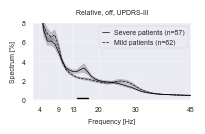

Cluster found between 14.0 Hz and 17.0 Hz.


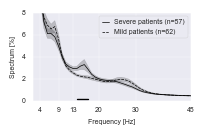

Cluster found between 14.0 Hz and 16.0 Hz.


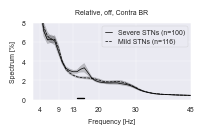

Cluster found between 14.0 Hz and 17.0 Hz.


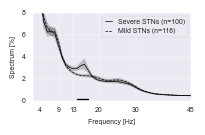

Cluster found between 13.0 Hz and 15.0 Hz.
Cluster found between 27.0 Hz and 45.0 Hz.


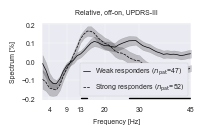

Cluster found between 13.0 Hz and 15.0 Hz.
Cluster found between 27.0 Hz and 45.0 Hz.


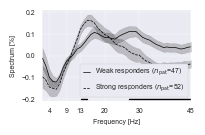

Cluster found between 13.0 Hz and 16.0 Hz.
Cluster found between 26.0 Hz and 30.0 Hz.
Cluster found between 32.0 Hz and 45.0 Hz.


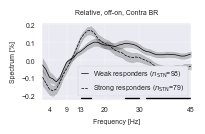

Cluster found between 13.0 Hz and 16.0 Hz.
Cluster found between 26.0 Hz and 30.0 Hz.
Cluster found between 32.0 Hz and 45.0 Hz.


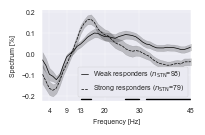

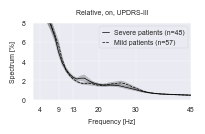

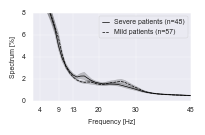

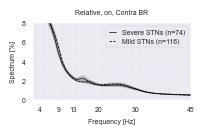

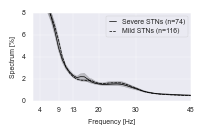

In [7]:
kind = 'normalized'
for cond in ['off', 'offon_abs', 'on']:
# for cond in ['off']:
    for lateralized_updrs in [False, True]:
    # for lateralized_updrs in [False]:
        for info_title in [True, False]:
        # for info_title in [False]:
            ylim = (-.2, .2) if cond == 'offon_abs' else (0, 8)
            plot_psd_by_severity_conds(kind, [cond], n_perm=n_perm, yscale='linear',
                                    lateralized_updrs=lateralized_updrs, color_by_kind=False,
                                    xmin=2, xmax=45, info_title=info_title,
                                    figsize=(2, 1.3), fig_dir='Figure1',
                                    xticks=XTICKS_FREQ_low,
                                    xticklabels=XTICKS_FREQ_low_labels,
                                    ylim=ylim)
    #         break
    #     break
    # break

# Figure 5: Within subjects ON

In [8]:
dataframes = get_dfs(ch_choice, equalize_subjects_norm_abs=True)

/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['sub_hemi_cond'] = df.sub_hemi + '_' + df.cond
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:81: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pivot['UPDRS_exists'] = pivot.UPDRS_bradyrigid_contra.notna()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:82: 

Cluster found between 8.0 Hz and 13.0 Hz.
Cluster found between 28.0 Hz and 60.0 Hz.
Cluster found between 23.0 Hz and 60.0 Hz.
Cluster found between 8.0 Hz and 9.0 Hz.
Cluster found between 29.0 Hz and 30.0 Hz.
Cluster found between 25.0 Hz and 33.0 Hz.
Cluster found between 43.0 Hz and 45.0 Hz.
Cluster found between 6.0 Hz and 60.0 Hz.
Cluster found between 10.0 Hz and 60.0 Hz.


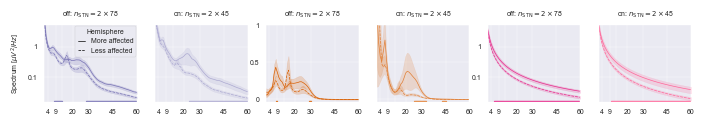

In [9]:
plot_psd_by_severity_kinds(['absolute', 'periodic', 'periodicAP'], ['off', 'on'], n_perm=n_perm,
                    lateralized_updrs=True,
                    info_title=None, legend=True,
                    figsize=(7, 1.2), xlabel=False,
                    # xticks=XTICKS_FREQ_high, xticklabels=XTICKS_FREQ_high_labels,
                    within_comparison=True, stat_height=3e-4)

Cluster found between 31.0 Hz and 32.0 Hz.
Cluster found between 39.0 Hz and 43.0 Hz.


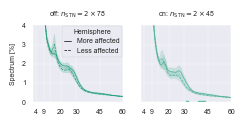

In [10]:
plot_psd_by_severity_kinds(['normalized'], ['off', 'on'], n_perm=n_perm,
                    lateralized_updrs=True,
                    # asymmetric_subjects=True,
                    info_title=None, legend=True,
                    figsize=(2.4, 1.2), xlabel=False,
                    ylim_norm=(0, 4),
                    # xticks=XTICKS_FREQ_high, xticklabels=XTICKS_FREQ_high_labels,
                    # leg_kws5{'loc': 'lower left'},
                    within_comparison=True)

In [11]:
# plot_psd_by_severity_conds('absolute', ['on'], n_perm=n_perm,
#                     lateralized_updrs=True,
#                     asymmetric_subjects=True,
#                     info_title=None, legend=True,
#                     figsize=(2.5, 1.5), leg_kws={'loc': 'lower left'},
#                     within_comparison=True)

In [12]:
# plot_psd_by_severity_conds('absolute', n_perm=n_perm,
#                     lateralized_updrs=True,
#                     asymmetric_subjects=True,
#                     info_title=None, legend=False,
#                     figsize=(2.5, 1.5), leg_kws={'loc': 'upper right'},
#                     within_comparison=True)

In [13]:
# plot_psd_by_severity_kinds(['absolute'], ['on'], n_perm=n_perm,
#                     lateralized_updrs=True,
#                     info_title=False,
#                     xscale='log',
#                     ylabel=False,
#                     within_comparison=True,
#                     legend=False,
#                     xlabel=False,
#                     yscale='log',
#                     xmin=13, xmax=200,
#                     # figsize=(1, .6))
#                     figsize=(.7, .5))

Cluster found between 23.0 Hz and 190.0 Hz.


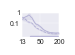

In [14]:
plot_psd_by_severity_conds('absolute', ['on'], n_perm=n_perm,
                    lateralized_updrs=True,
                    # asymmetric_subjects=True,
                    info_title=False,
                    xscale='log', ylabel=False,
                    within_comparison=True,
                    legend=False, xlabel=False,
                    yscale='log',
                    xmin=13, xmax=200,
                    xticks=[13, 50, 200], xticklabels=[13, 50, 200],
                    yticks=[0.1, 1], yticklabels=[0.1, 1],
                    ylim=(0.006, 1), stat_height=0.0015,
                    # figsize=(1, .6))
                    figsize=(.7, .5))

Cluster found between 28.0 Hz and 103.0 Hz.
Cluster found between 105.0 Hz and 124.0 Hz.
Cluster found between 126.0 Hz and 132.0 Hz.


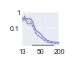

In [15]:
plot_psd_by_severity_conds('absolute', ['off'], n_perm=n_perm,
                    lateralized_updrs=True,
                    info_title=False,
                    yscale='log',
                    xscale='log', ylabel=False,
                    within_comparison=True,
                    legend=False, xlabel=False,
                    xmin=13, xmax=200,
                    xticks=[13, 50, 200], xticklabels=[13, 50, 200],
                    yticks=[0.1, 1], yticklabels=[0.1, 1],
                    ylim=(0.008, 1), stat_height=0.001,
                    # ylim=None,
                    # figsize=(1, .6))
                    figsize=(.7, .6))

Cluster found between 25.0 Hz and 33.0 Hz.
Cluster found between 43.0 Hz and 45.0 Hz.


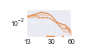

In [16]:
plot_psd_by_severity_conds('periodic', ['on'], n_perm=n_perm,
                    lateralized_updrs=True,
                    info_title=False,
                    xscale='log', ylabel=False,
                    within_comparison=True,
                    legend=False, xlabel=False,
                    yscale='log',
                    xmin=13, xmax=60,
                    # yticks=[0.001, 0.1], yticklabels=[0.001, 0.1],
                    xticks=[13, 30, 60], xticklabels=[13, 30, 60],
                    ylim=(4e-5, 1), stat_height=2e-5,
                    # figsize=(1, .6))
                    figsize=(.8, .5))

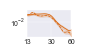

In [17]:
plot_psd_by_severity_conds('periodic', ['off'], n_perm=n_perm,
                    lateralized_updrs=True,
                    info_title=False,
                    xscale='log', ylabel=False,
                    within_comparison=True,
                    legend=False, xlabel=False,
                    yscale='log',
                    xmin=13, xmax=60,
                    # yticks=[0.001, 0.1], yticklabels=[0.001, 0.1],
                    xticks=[13, 30, 60], xticklabels=[13, 30, 60],
                    ylim=(4e-5, 1), stat_height=2e-5,
                    # figsize=(1, .6))
                    figsize=(.8, .5))

# Figure 5 Supplementary Plots

## Periodic gamma for adjacent channels

In [18]:
ch_choice = 'ch_adj_beta_high_max_off'
dataframes = get_dfs(ch_choice, equalize_subjects_norm_abs=True)

/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['sub_hemi_cond'] = df.sub_hemi + '_' + df.cond
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:81: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pivot['UPDRS_exists'] = pivot.UPDRS_bradyrigid_contra.notna()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:82: 

Cluster found between 28.0 Hz and 35.0 Hz.
Cluster found between 37.0 Hz and 60.0 Hz.
Cluster found between 23.0 Hz and 60.0 Hz.
Cluster found between 29.0 Hz and 31.0 Hz.
Cluster found between 24.0 Hz and 35.0 Hz.
Cluster found between 11.0 Hz and 60.0 Hz.
Cluster found between 16.0 Hz and 60.0 Hz.


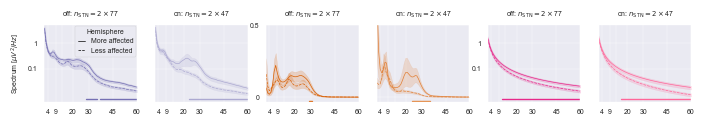

In [19]:
plot_psd_by_severity_kinds(['absolute', 'periodic', 'periodicAP'], ['off', 'on'], n_perm=n_perm,
                    lateralized_updrs=True,
                    info_title=None, legend=True,
                    figsize=(7, 1.2), xlabel=False,
                    ylim_abs=(0.005, 5), ylim_ap=(0.005, 5), ylim_per=(-0.035, .5),
                    # xticks=XTICKS_FREQ_high, xticklabels=XTICKS_FREQ_high_labels,
                    within_comparison=True, stat_height=3e-4)

Cluster found between 24.0 Hz and 35.0 Hz.


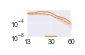

In [20]:
plot_psd_by_severity_conds('periodic', ['on'], n_perm=n_perm,
                    lateralized_updrs=True,
                    info_title=False,
                    xscale='log', ylabel=False,
                    within_comparison=True,
                    legend=False, xlabel=False,
                    yscale='log',
                    xmin=13, xmax=60,
                    # yticks=[0.001, 0.1], yticklabels=[0.001, 0.1],
                    xticks=[13, 30, 60], xticklabels=[13, 30, 60],
                    ylim=(1e-8, .5), stat_height=1e-8,
                    # figsize=(1, .6))
                    figsize=(.8, .5))

Cluster found between 29.0 Hz and 31.0 Hz.


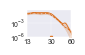

In [21]:
plot_psd_by_severity_conds('periodic', ['off'], n_perm=n_perm,
                    lateralized_updrs=True,
                    info_title=False,
                    xscale='log', ylabel=False,
                    within_comparison=True,
                    legend=False, xlabel=False,
                    yscale='log',
                    xmin=13, xmax=60,
                    # yticks=[0.001, 0.1], yticklabels=[0.001, 0.1],
                    xticks=[13, 30, 60], xticklabels=[13, 30, 60],
                    ylim=(1e-6, .5), stat_height=1e-6,
                    # figsize=(1, .6))
                    figsize=(.8, .5))

Cluster found between 37.0 Hz and 188.0 Hz.


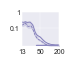

In [22]:
plot_psd_by_severity_conds('absolute', ['off'], n_perm=n_perm,
                    lateralized_updrs=True,
                    info_title=False,
                    yscale='log',
                    xscale='log', ylabel=False,
                    within_comparison=True,
                    legend=False, xlabel=False,
                    xmin=13, xmax=200,
                    xticks=[13, 50, 200], xticklabels=[13, 50, 200],
                    yticks=[0.1, 1], yticklabels=[0.1, 1],
                    ylim=(0.008, 1), stat_height=0.001,
                    # ylim=None,
                    # figsize=(1, .6))
                    figsize=(.7, .6))

Cluster found between 23.0 Hz and 94.0 Hz.
Cluster found between 96.0 Hz and 124.0 Hz.
Cluster found between 127.0 Hz and 134.0 Hz.
Cluster found between 138.0 Hz and 144.0 Hz.


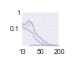

In [23]:
plot_psd_by_severity_conds('absolute', ['on'], n_perm=n_perm,
                    lateralized_updrs=True,
                    info_title=False,
                    yscale='log',
                    xscale='log', ylabel=False,
                    within_comparison=True,
                    legend=False, xlabel=False,
                    xmin=13, xmax=200,
                    xticks=[13, 50, 200], xticklabels=[13, 50, 200],
                    yticks=[0.1, 1], yticklabels=[0.1, 1],
                    ylim=(0.008, 1), stat_height=0.001,
                    # ylim=None,
                    # figsize=(1, .6))
                    figsize=(.7, .6))

In [24]:
# for kind in ['absolute', 'periodic', 'periodicAP']:
#     for cond in ['off', 'on', 'offon_abs']:
#         for within_comparison in [True, False]:
#         # for within_comparison in [False]:
#             for lateralized_updrs in [True, False]:
#             # for lateralized_updrs in [False]:
#                 if within_comparison and (not lateralized_updrs or (cond == 'offon_abs')):
#                     continue
#                 if cond == 'offon_abs':
#                     yscale = 'linear'
#                 else:
#                     yscale = 'log'
#                 if kind == 'periodic':
#                     yscale = 'linear'
#                 plot_psd_by_severity_conds(kind, [cond], within_comparison=within_comparison,
#                                         lateralized_updrs=lateralized_updrs,
#                                         yscale=yscale,
#                                         n_perm=n_perm, info_title=True)
#         #         break
#         #     break
#         # break